<a href="https://colab.research.google.com/github/gomdoori/AI/blob/main/PINN_1_(Termination_Speed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

In [ ]:
# 디바이스 할당
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('drive/MyDrive/Colab Notebooks/PINN/Deeplearning_class/PINN_ex1.xlsx')

In [ ]:
data

,time,Height(m)
0,0.0,1000.000
1,0.2,999.804
2,0.4,999.216
3,0.6,998.236
4,0.8,996.864
...,...,...
66,13.2,146.224
67,13.4,120.156
68,13.6,93.696
69,13.8,66.844


In [ ]:
train_time = 40

In [ ]:
x_train = data.loc[:train_time,'time'].values
y_train = data.loc[:train_time,'Height(m)'].values

In [ ]:
x_test = data.loc[train_time+1:,'time'].values
y_test = data.loc[train_time+1:,'Height(m)'].values

In [ ]:
x_train = torch.Tensor(x_train).reshape(-1,1).to(device)
y_train = torch.Tensor(y_train).reshape(-1,1).to(device)

In [ ]:
x_test = torch.Tensor(x_test).reshape(-1,1).to(device)
y_test = torch.Tensor(y_test).reshape(-1,1).to(device)

In [ ]:
x_train.shape

torch.Size([41, 1])

In [ ]:
n_input = 1
n_output = 1
n_hidden = 50

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.l1 = nn.Linear(n_input, n_hidden)
        self.l2 = nn.Linear(n_hidden, n_hidden)
        self.l3 = nn.Linear(n_hidden, n_hidden)
        self.l4 = nn.Linear(n_hidden, n_output)

        # ReLU 함수 정의
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        x = self.relu(x)
        x = self.l3(x)
        x = self.relu(x)
        x = self.l4(x)
        return x

In [ ]:
torch.cuda.manual_seed(123)

model = Net()
model = model.to(device)

lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
print(model)

Net(
  (l1): Linear(in_features=1, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=50, bias=True)
  (l3): Linear(in_features=50, out_features=50, bias=True)
  (l4): Linear(in_features=50, out_features=1, bias=True)
  (relu): ReLU()
)


In [ ]:
loss_train_record=[]
loss_test_record=[]
for epoch in range(10000):
  optimizer.zero_grad()

  preds_train = model(x_train)
  preds_test = model(x_test)

  loss_train = nn.MSELoss()(preds_train,y_train)
  loss_test = nn.MSELoss()(preds_test,y_test)

  loss_train.backward()
  optimizer.step()

  loss_train_record.append(loss_train.item())
  loss_test_record.append(loss_test.item())
  if epoch % 1000 == 0:
    print(f'epoch{epoch} loss:{loss_train.item()}, loss_valid:{loss_test.item()}')

epoch0 loss:808711.25, loss_valid:181251.921875
epoch1000 loss:538.0316162109375, loss_valid:410789.65625
epoch2000 loss:458.7069091796875, loss_valid:371059.40625
epoch3000 loss:244.23675537109375, loss_valid:304435.75
epoch4000 loss:57.37724304199219, loss_valid:215590.375
epoch5000 loss:12.987024307250977, loss_valid:177558.515625
epoch6000 loss:5.377129554748535, loss_valid:161308.0625
epoch7000 loss:3.830388307571411, loss_valid:153535.9375
epoch8000 loss:3.169776678085327, loss_valid:149347.625
epoch9000 loss:2.8523168563842773, loss_valid:147978.484375


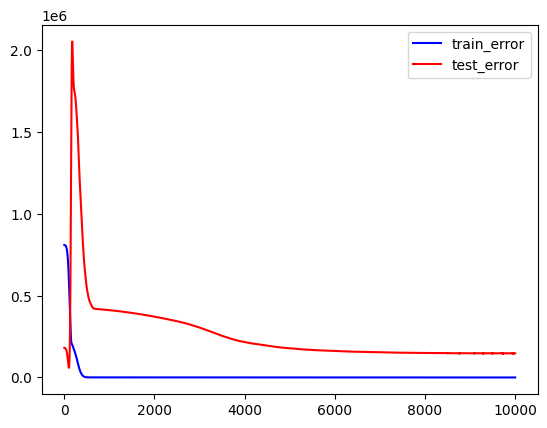

In [ ]:
plt.plot(loss_train_record,'b',label='train_error')
plt.plot(loss_test_record,'r',label='test_error')
plt.legend()
plt.show()

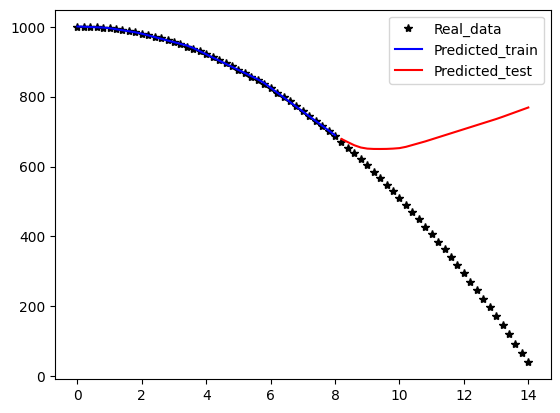

In [ ]:
# Plot
plt.plot(data['time'],data['Height(m)'],'*',color='black',label='Real_data')
plt.plot(x_train.cpu(),preds_train.detach().cpu(),color='blue',label='Predicted_train')
plt.plot(x_test.cpu(),preds_test.detach().cpu(),color='red',label='Predicted_test')
plt.legend(loc = 'upper right')

In [ ]:
def ODE(t):
  return -9.8*t

In [ ]:
# Set Boundary conditions and initial point:
x_H0=torch.Tensor([0])
y_H0=torch.Tensor([1000])

In [ ]:
# Set the number of collocation points

time_start = data.loc[0,'time']
time_end = data.loc[len(data)-1,'time']

N_colloc = 1000

# Collocation points
X_colloc = torch.rand(N_colloc,1)*(time_end-time_start)+time_start

In [ ]:
#Store tensors to GPU
X_colloc=X_colloc.to(device)
x_H0=x_H0.to(device)
y_H0=y_H0.to(device)

In [ ]:
class PINN_test(nn.Module):
    ##Neural Network
    def __init__(self):
        super().__init__() #call __init__ from parent class

        self.tanh = nn.Tanh()

        self.l1 = nn.Linear(1, 50)
        self.l2 = nn.Linear(50, 50)
        self.l3 = nn.Linear(50, 50)
        self.l4 = nn.Linear(50, 1)

    def forward(self, x):
        x = self.l1(x)
        x = self.tanh(x)
        x = self.l2(x)
        x = self.tanh(x)
        x = self.l3(x)
        x = self.tanh(x)
        x = self.l4(x)
        return x

In [ ]:
# 난수 고정
torch.cuda.manual_seed(123)
# 모델 인스턴스 생성
model_P = PINN_test()
# 모델을 GPU로 전송
model_P = model_P.to(device)
# 최적화 알고리즘: 경사 하강법
optimizer_P = torch.optim.Adam(model_P.parameters(), lr=lr)

In [ ]:
loss_train_P=[]
loss_test_P=[]
steps=50000
for i in range(steps):
    loss_BC=nn.MSELoss()(model_P.forward(x_H0),y_H0)
    X_colloc.requires_grad=True
    f=model_P.forward(X_colloc)
    f_x=autograd.grad(f,X_colloc,torch.ones([X_colloc.shape[0],1]).to(device),
                      retain_graph=True, create_graph=True)[0]
    loss_ODE=nn.MSELoss()(f_x,ODE(X_colloc))
    loss_Data=nn.MSELoss()(model_P.forward(x_train),y_train)

    loss = loss_BC + loss_ODE + loss_Data# use mean squared error

    loss_test = nn.MSELoss()(model_P.forward(x_test),y_test)
    optimizer_P.zero_grad()
    loss.backward()
    optimizer_P.step()


    loss_train_P.append(loss.item())
    loss_test_P.append(loss_test.item())
    if i%(steps/10)==0:
      print(loss)

tensor(1814521.5000, device='cuda:0', grad_fn=<AddBackward0>)
tensor(990040.8750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(445853.8750, device='cuda:0', grad_fn=<AddBackward0>)
tensor(128422.7812, device='cuda:0', grad_fn=<AddBackward0>)
tensor(11937.5479, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.9260, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3364, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0072, device='cuda:0', grad_fn=<AddBackward0>)


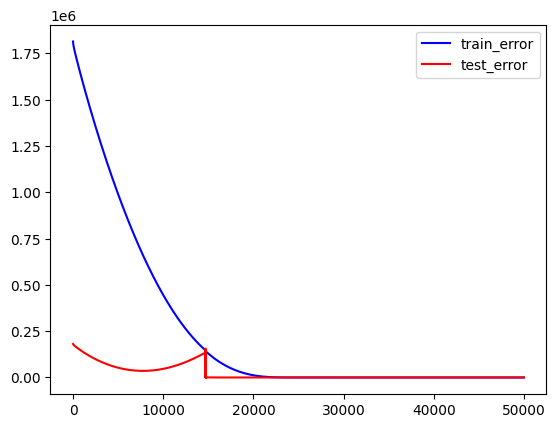

In [ ]:
plt.plot(loss_train_P,'b',label='train_error')
plt.plot(loss_test_P,'r',label='test_error')
plt.legend()
plt.show()

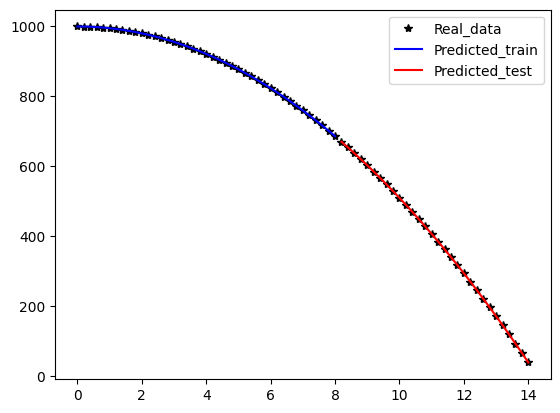

In [ ]:
# Plot
plt.plot(data['time'],data['Height(m)'],'*',color='black',label='Real_data')
plt.plot(x_train.cpu(),model_P(x_train).detach().cpu(),color='blue',label='Predicted_train')
plt.plot(x_test.cpu(),model_P(x_test).detach().cpu(),color='red',label='Predicted_test')
plt.legend(loc = 'upper right')